### The learning objective is to used open source mainly python,and OpenCV, to find lanes with varies techinques such as:

1. Greyscale
2. Canny algorithm 
3. Region of interest selection and draw lines 
4. Hough transformation

Then, applying these methods on still images and eventually applying to short videos those techniques on a video. 
That shows how powerful OpenCV can be do. 

**Those are the output goal on this project**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>


## Import packages and read an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


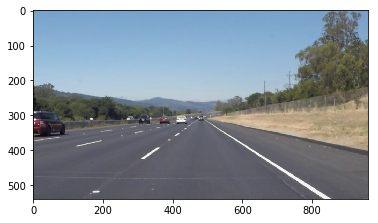

In [1]:
#importing some packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [2]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [3]:
#loop through all the images
def show_all_images(images):    
    plt.figure(figsize=(10,11))
    for i, image in enumerate(images):
        plt.subplot(3, 2, i+1)
        plt.imshow(image)
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

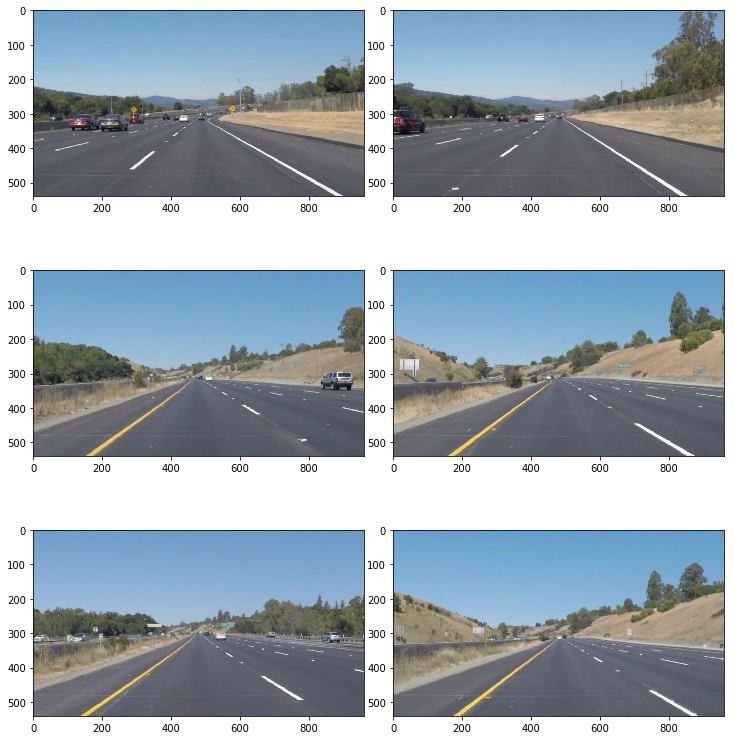

In [4]:
#take a peek and look at how are they images look like
import glob
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_all_images(test_images)


## Applying different image filter techniques and visualize them 

Convert RGB to grayscale
Darken the grayscale (to reduce contrast in discolored sections of road)
Convert RGB to HSV

Isolate yellow in HSV to produce a yellow mask
Also isolate white in HSV to produce a white mask
Combine yellow and white masks with bitwise OR
Apply combined mask to darkened grayscale with bitwise OR
Apply a slight Gaussian blur
Perform Canny edge detection
Define a region of interest and mask away the undesired portions of the image
Retrieve Hough lines
Consolidate and extrapolate lines and apply them to the original image

Both HSV and HSL converted image, has the strong lane line highlighed in blue or yellow lime ish tone. 

To be more accurately picking up the lane, few steps that I am going to take to manipulated to images. 


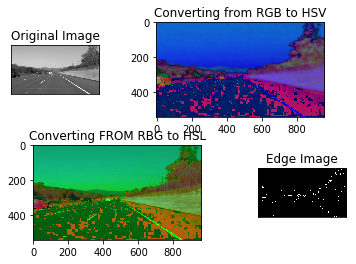

In [5]:
#first plot and see how does the image look in different filters
from PIL import Image
images = np.array(Image.open('test_images/solidWhiteRight.jpg'))
gray = cv2.cvtColor(images,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(images,(5,5),0)

plt.imshow(gray, cmap='gray')
plt.title('Turning into grey scale')

edges = cv2.Canny(blur, 50, 150)

green = np.uint8([[[255,255,0 ]]])
hsv_green = cv2.cvtColor(images,cv2.COLOR_BGR2HLS)
hsv = cv2.cvtColor(images, cv2.COLOR_BGR2HSV)

grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[1, :2]),plt.imshow(hsv_green,cmap = 'gray')
plt.title('Converting FROM RBG to HSL')

plt.subplot(grid[0, 1:]),plt.imshow(hsv,cmap = 'gray')
plt.title('Converting from RGB to HSV')

plt.subplot(grid[0, 0]),plt.imshow(gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(grid[1, 2]),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()


##Processing functions 
Helper functions and parameters for the region of interest. 
OpenCV defaults 

In [6]:
kernel_size = 9
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_roi(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # define vertices by four points
    imshape = img.shape
    vertices = np.array([[(50, 539), (900, 539), (470, 280), (480, 280)]], dtype=np.int32)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    for line in lines:
        cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


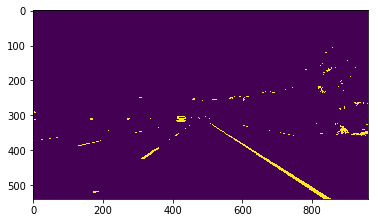

In [7]:
hsv = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
gray = cv2.bitwise_or(yellow, white)
plt.imshow(gray)
plt.show()

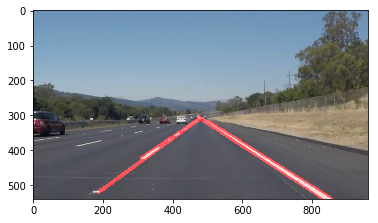

In [8]:
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]
vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
hsv = cv2.cvtColor((image), cv2.COLOR_RGB2HSV)
yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
gray = cv2.bitwise_or(yellow, white)
edges = canny(gray, 64, 192)
roi = get_roi(edges, vertices)
out = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
result = weighted_img(image, out, 0.9, 0.9)
plt.imshow(result)
plt.show()

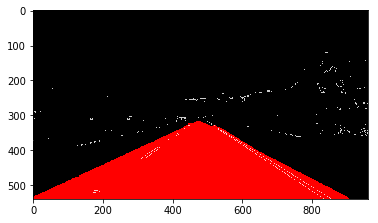

In [10]:
rho = 2            #distance resolution in pixels of the Hough grid
theta = np.pi/180  #angular resolution in radians of the Hough grid
threshold = 20     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 25  #minimum number of pixels making up a line
max_line_gap = 10  #maximum gap in pixels between connectable line segments

masked = get_roi(edges, vertices)
cv2.fillPoly(masked, vertices, 255)

color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1.0, 0.) 
plt.imshow(lines_edges)

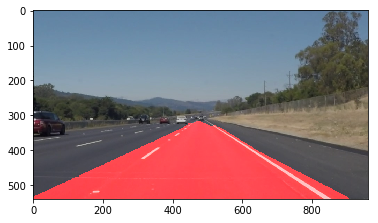

In [12]:

#vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)    
masked = get_roi(edges, vertices)
cv2.fillPoly(masked, vertices, 255)
    
rho = 2            #distance resolution in pixels of the Hough grid
theta = np.pi/180  #angular resolution in radians of the Hough grid
threshold = 20     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 25  #minimum number of pixels making up a line
max_line_gap = 10  #maximum gap in pixels between connectable line segments
line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    
result = weighted_img(line_image, image)
plt.imshow(result)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [13]:
import math
import numpy as np
def get_roi(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [14]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

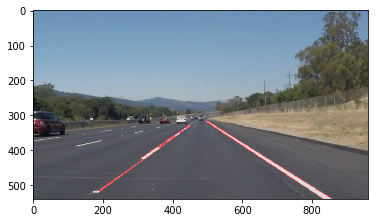

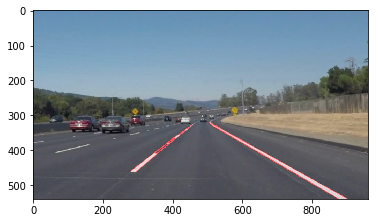

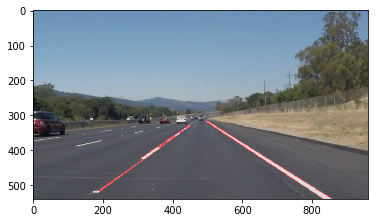

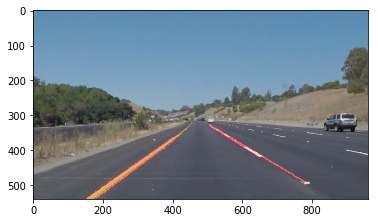

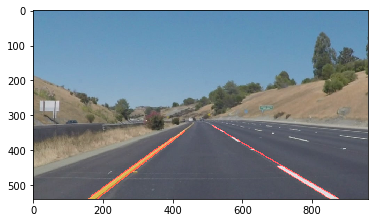

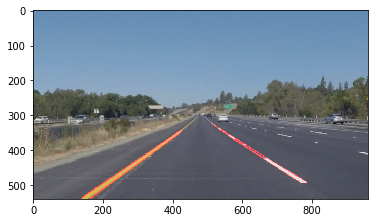

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

test_images_output = os.listdir('test_images/')

for i in test_images_output:
    i = 'test_images/' + i
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(425, 315), (540, 315), (imshape[1],imshape[0])]], \
                        dtype=np.int32)    

    hsv = cv2.cvtColor((image), cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, 64, 192)
    roi = get_roi(edges, vertices)
    out = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
    result = weighted_img(image, out, 0.9, 0.9)    
    
    image = mpimg.imread(i)
    plt.imshow(result)
    plt.show()
    

After plotting trying that on different images, the yellow lane on left does well. Yet detection does alright on the white lane. 


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
import imageio
imageio.plugins.ffmpeg.download()

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    hsv = cv2.cvtColor((image), cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, 64, 192)
    roi = get_roi(edges, vertices)
    out = hough_lines(roi, 1, np.pi/180, 32, 1, 200)
    result = weighted_img(image, out, 0.9, 0.9)    
    return result



Let's try the one with the solid white lane on the right first ...

In [19]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.12 s, sys: 707 ms, total: 4.83 s
Wall time: 7.24 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.2 s, sys: 2.28 s, total: 15.5 s
Wall time: 23.3 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections:
This is literally my first project on computer vision without having too much input yet. 
Successful metrics on this project would be having a great lane finding on both still and video clip. From the still images, I think it is perfect. The video does well on the first one. On the second video clip, the left yellow lane has a shorter detection yet still good. and the right lane is doing alright, but not the best. 
However, I think this might not the AI/smarter way to do that. Tho there are lots of success with a small amount of data. I was thinking about applying nerual network or recurrent neural network for a more robust solution. 

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 58%|█████▊    | 145/251 [00:10<00:07, 14.38it/s]

TypeError: 'NoneType' object is not iterable

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

 58%|█████▊    | 145/251 [00:30<00:21,  4.83it/s]